# Shipments of medicines between 2007-2015 to Africa

LINK TO KAGGLE DATASET: https://www.kaggle.com/divyeshardeshana/supply-chain-shipment-pricing-data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

import geopy.distance
%matplotlib inline

In [2]:
df = pd.read_csv("SCMS_Delivery_History_Dataset.csv")

In [3]:
df.shape

(10324, 33)

In [4]:
df.head()

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


## Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            10324 non-null  int64  
 1   Project Code                  10324 non-null  object 
 2   PQ #                          10324 non-null  object 
 3   PO / SO #                     10324 non-null  object 
 4   ASN/DN #                      10324 non-null  object 
 5   Country                       10324 non-null  object 
 6   Managed By                    10324 non-null  object 
 7   Fulfill Via                   10324 non-null  object 
 8   Vendor INCO Term              10324 non-null  object 
 9   Shipment Mode                 9964 non-null   object 
 10  PQ First Sent to Client Date  10324 non-null  object 
 11  PO Sent to Vendor Date        10324 non-null  object 
 12  Scheduled Delivery Date       10324 non-null  object 
 13  D

Shipment Mode : 360  |  3.49 %
Dosage : 1736  |  16.82 %
Line Item Insurance (USD) : 287  |  2.78 %


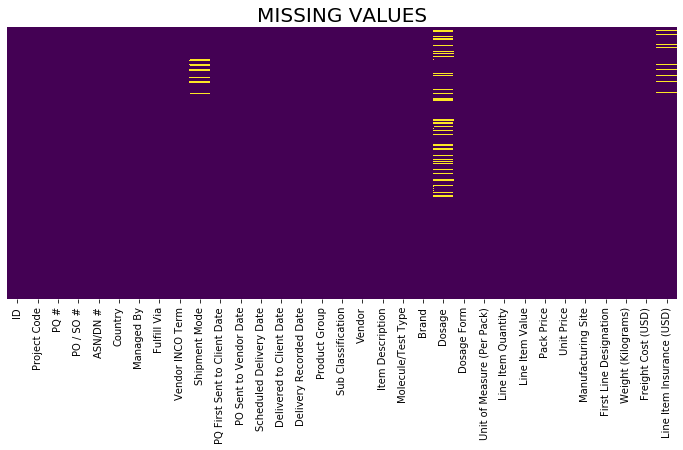

In [6]:
plt.figure(figsize = (12, 5))
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = "viridis")
plt.title("MISSING VALUES", fontsize =20)

for x in df.columns:
    if df[x].isna().sum() > 0:
        print(x, ": {miss}  |  {per} %".format(miss = df[x].isna().sum(),
                                               per = round(df[x].isna().sum()/len(df)*100, 2) ))             

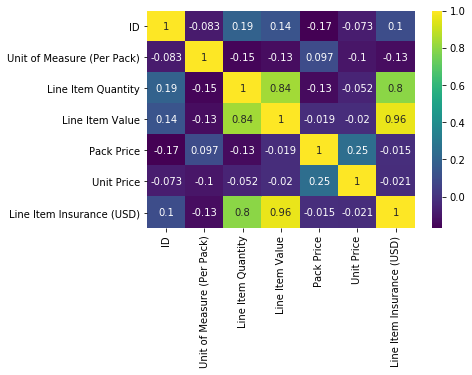

In [7]:
sns.heatmap(df.corr(), cmap = "viridis", annot = True)

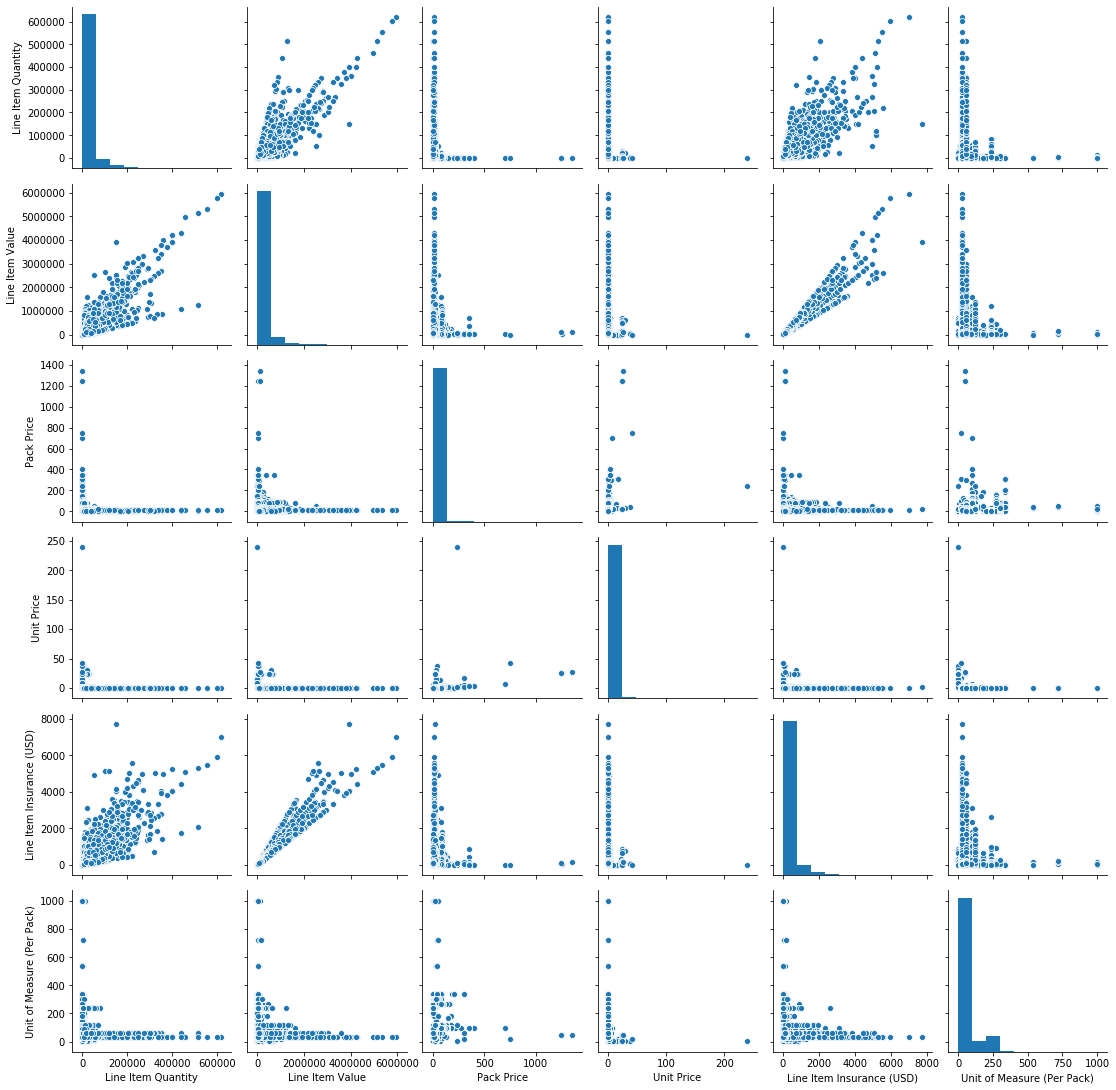

In [8]:
sns.pairplot(data = df[["Line Item Quantity", "Line Item Value", "Pack Price",
                        "Unit Price", "Line Item Insurance (USD)", "Unit of Measure (Per Pack)"]], dropna = True)

## Data cleaning

In [9]:
# Drop ID and PQ number (PQs will be treated later on)
df.drop(["ID", "Project Code"], axis = 1, inplace = True)

# These two columns contain almost the same information
df.drop(["Molecule/Test Type", "Item Description"], axis = 1, inplace = True)

# Vendor contains useless data
df.drop(["Vendor", "Brand"], axis = 1, inplace = True)

# The following codes are useless
df.drop(["PQ #", "ASN/DN #", "PO / SO #"], axis = 1, inplace = True)

In [10]:
# Dates columns

df["Scheduled Delivery Date"] = pd.to_datetime(df["Scheduled Delivery Date"])
df["Delivered to Client Date"] = pd.to_datetime(df["Delivered to Client Date"])
df["Delivery Recorded Date"] = pd.to_datetime(df["Delivery Recorded Date"])

# Delays
df["Delay on Schedule"] = (df["Delivered to Client Date"] - df["Scheduled Delivery Date"]).dt.days.astype('int64')
df["Recorded Delay"] = (df["Delivery Recorded Date"] - df["Delivered to Client Date"]).dt.days.astype('int64')
df["Recorded Delay on Schedule"] = (df["Delivery Recorded Date"] - df["Scheduled Delivery Date"]).dt.days.astype('int64')

# Date, month, year of th scheduled delivery
df["Scheduled Delivery Date_y"] = df["Scheduled Delivery Date"].dt.year
df["Scheduled Delivery Date_m"] = df["Scheduled Delivery Date"].dt.month
df["Scheduled Delivery Date_d"] = df["Scheduled Delivery Date"].dt.day

df.drop(["Scheduled Delivery Date", "Delivered to Client Date", "Delivery Recorded Date"], axis = 1, inplace = True)

In [11]:
# First Line Designation (Yes = 1, No = 0)
df["First Line Designation"] = pd.get_dummies(df["First Line Designation"], drop_first = True)

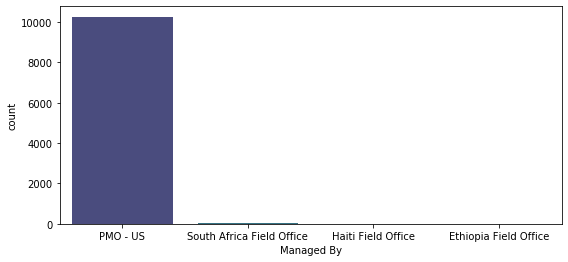

In [12]:
# Managed by
plt.figure(figsize = (9, 4)); sns.countplot(df["Managed By"], palette = "viridis")

# Drop the lines where the shipment was managed by Haiti or Ethiopia Field Office, since their "Dosage" is missing
df.drop(df[df["Managed By"] == "Ethiopia Field Office"].index, inplace = True)
df.drop(df[df["Managed By"] == "Haiti Field Office"].index, inplace = True)

# This leads to a dichotomous variable (nevertheless very unbalanced) --- Yes = 1, No = 0
df["SAFO_managed"] = pd.get_dummies(df["Managed By"], drop_first = True)
df.drop("Managed By", axis = 1, inplace = True)

df.reset_index(drop = True, inplace = True)

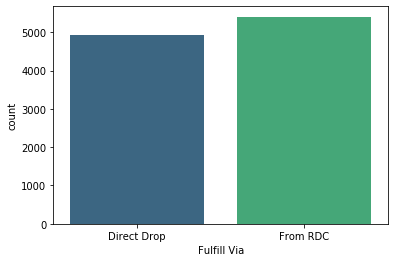

In [13]:
# Fulfill Via
sns.countplot(df["Fulfill Via"], palette = "viridis")

# "Fulfill Via" has only two features, that also are fairly well balanced
# Direct Drop = 1 / From RDC = 0

df["Direct_drop"] = pd.get_dummies(df["Fulfill Via"], drop_first = True)
df["Direct_drop"] = df["Direct_drop"].apply(lambda x: 1 if x == 0 else 0)
df.drop("Fulfill Via", axis = 1, inplace = True)

```python
# Vendor
import textdistance#.Levenshtein import levenshtein

l = []
for x in range(len(df)):
    l += [ (len(df["Vendor"][x]) - len(df["Manufacturing Site"][x]),
            textdistance.levenshtein(df["Vendor"][x], df["Manufacturing Site"][x])) ]

#df["Vendor"]
```

In [14]:
# Manufacturing Site

man_site = pd.read_table("man_site.txt", sep = "|")
dms = dict(zip(man_site["Site"], [ (man_site["Latitude"][x], man_site["Longitude"][x])
                                  for x in range(len(man_site)) ]))

df["Manufacturing Site Coords"] = df["Manufacturing Site"].map(dms)
df.drop("Manufacturing Site", axis = 1, inplace = True)

In [15]:
# Country

coun_coord = pd.read_table("country_loc.txt", sep = "|")
dcc = dict(zip(coun_coord["Country"], [ (coun_coord["Latitude"][x], coun_coord["Longitude"][x])
                                       for x in range(len(coun_coord)) ]))

df["Country Coords"] = df["Country"].map(dcc)
df.drop("Country", axis = 1, inplace = True)

In [16]:
# New col: Distance

df["Distance Manuf Dest"] = [ geopy.distance.distance(df["Country Coords"][x], df["Manufacturing Site Coords"][x]).km
                             for x in range(len(df)) ]

C:\Users\matti\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\matti\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\matti\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\matti\anaconda3\lib\site-packages\ipykernel_launch

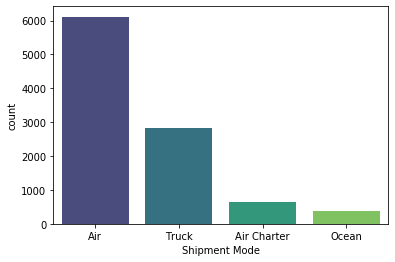

In [17]:
# Shipment Mode
sns.countplot(df["Shipment Mode"], palette = "viridis")

# Make Air Charter and Air the same value (= Air) IT IS OK WITH 3 DIMENSIONS
df["Shipment Mode"] = df["Shipment Mode"].apply(lambda x: x if x != "Air Charter" else "Air")

# Fill NaN (RMK: only the 0.03% of the rows in this column was empty)
# 1) according to the pairplot of df (hue = "Shipment Mode"), all "Unit Price" > 7.50 are shipped through AIR
# 2) The high unbalance toward air in "First Line Designation" made fill all rows where it was equal to 1 with "Air"
# 3) Among the rows where "First Line Designation", those with "Direct drop" == 0 where almost all "Air"
# 4) Finally, the remaining had "Vendor" that was almost always associated with "Truck"

def filler_ship(d):
    for x in range(len(d)):
        if type(d["Shipment Mode"][x]) != str and d["Unit Price"][x] > 7.5: d["Shipment Mode"][x] = "Air"
    for x in range(len(d)):
        if type(d["Shipment Mode"][x]) != str and d["First Line Designation"][x] == 1: d["Shipment Mode"][x] = "Air"
    for x in range(len(d)):
        if type(d["Shipment Mode"][x]) != str and d["Direct_drop"][x] == 0: d["Shipment Mode"][x] = "Air"
    for x in range(len(d)):
        if type(d["Shipment Mode"][x]) != str: d["Shipment Mode"][x] = "Truck"
    return d

df = filler_ship(df)

df = pd.concat([df, pd.get_dummies(df["Shipment Mode"])], axis = 1)

In [18]:
df["Sub Classification"].value_counts()

Adult                   6595
Pediatric               1955
HIV test                1565
HIV test - Ancillary     161
Malaria                   30
ACT                       16
Name: Sub Classification, dtype: int64

In [19]:
# Dosage
# After evaluation on NaN, it is possible to see that all have a "Dosage Form" that includes "Test kit"
# and have "Product Group" equal to HRTD or MRTD that stand for RAPID TEST DEVICE of HIV or MALARY

# Since these diseases are still hard to fight, dropping this information would be costly.
# Therefore, I've decided to drop the column "Dosage" due to the amount of empty values,
# and keep the information on the disease from the column "Sub Classification"

df.drop("Dosage", axis = 1, inplace = True)

In [20]:
# Weight & Freight Cost
# roughly 15% of the column values is equal to "Weight Captured Separately", which is the same as NaN
# roughly 25% of the column values is "See Project Code ...", with no more clue provided
# Due to the high number of this types of value, the column is to be dropped
# The same stands for Freight Cost

df.drop(["Weight (Kilograms)", "Freight Cost (USD)"], axis = 1, inplace = True)

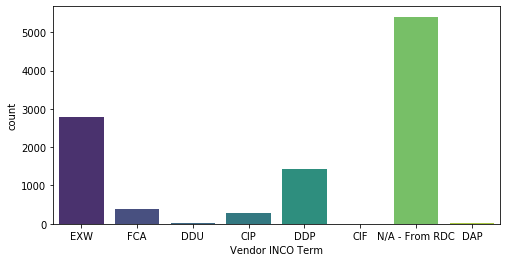

In [21]:
# Vendor INCO Term
plt.figure(figsize = (8,4)); sns.countplot(df["Vendor INCO Term"], palette = "viridis")

# After careful analysis, this column is somehow redundant, because
# all values of "N/A - From RDC" have Direct_drop = 0,
# all the other INCOs have Direct_drop = 1.
# This insight led me to drop this column

df.drop("Vendor INCO Term", axis = 1, inplace = True)

The INCO terms are defined as the terms that denote the points at which shipper, carrier, and consignee risk and responsibility start and end. There are currently 13 Incoterms in use. Here only those present in the dataset are listed.
- **EXW (Ex-Works)**: the seller, or exporter, makes the goods available to the buyer, or importer at the seller's premises. The buyer is responsible for all transportation costs, duties, and insurance, and accepts risk of loss of goods immediately after the goods are purchased and placed outside the factory door. The Ex-Works Price does not include loading goods onto a truck or vessel. Under EXW, sellers minimize their risk by making the goods available at their factory or place of business.
- **FCA (Free Carrier)**: the seller, or exporter, clears the goods for export and delivers them to the carrier and place specified by the buyer. If the place chosen is the seller's place of business, the seller must load the goods onto the transport vehicle; otherwise, the buyer is responsible for loading the goods. The buyer assumes risk of loss from that point forward and must pay for all costs associated with transporting the goods to the final destination.
- **DDU (Delivered Duty Unpaid)**: the seller, or exporter, is responsible for all costs involved in delivering the goods to a named place of destination where the goods are placed at the disposal of the buyer. The buyer, or importer, assumes risk of loss at that point and must clear customs, pay duties, and provide inland transportation and insurance to the final destination.
- **CIP (Carriage and Insurance Paid To)**: the seller transports the goods to the port of export, clears customs, and delivers them to the carrier. From that point, risk of loss shifts to the buyer. The seller is responsible for carriage and insurance costs to the named place of destination. The buyer is responsible for all costs, and bears risk of loss from that point forward.
- **DDP (Delivered Duty Paid)**: the seller, or exporter, is responsible for all costs involved in delivering the goods to a named place of destination and for clearing customs in the country of import. The seller provides literally door-to-door delivery, including customs clearance in the port of export and the port of destination. Thus the seller bears the entire risk of loss until goods are delivered to the buyer's premises.
- **CIF (Cost, Insurance & Freight)**: the seller, or exporter, is responsible for delivering the goods onto the vessel of transport and clearing customs in the country of export. The exporter is also responsible for purchasing insurance, with the buyer (importer) named as the beneficiary. Risk of loss transfers to buyer as the goods cross the ship's rail. The buyer must clear customs in the country of import and pay for all other transport and insurance in the country of import. CIF can be used only when the international transport of goods is at least partially by water.
- **DAP (Delivered At Place)**: the seller is responsible for delivery of the goods, ready for unloading, at the named place of destination. The seller assumes all risks involved up to unloading. Unloading is at the buyer’s risk and cost. DAP rules require the seller to clear goods for export without any obligation to clear the goods for import, pay import duty or carry out import customs formalities.

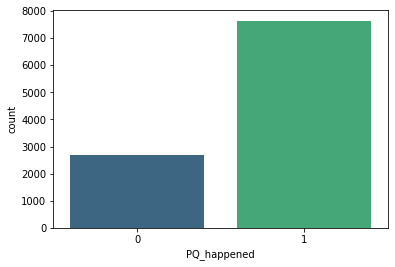

In [22]:
# PQ and PO are the last two phases of medical devices validation

# PQ First Sent to Client Date

# Add the column "PQ_happened" as dichotomous,
# with 1 where the "PQ First Sent to Client Date" column has a date,
# 0 when the column reported either "Pre-PQ Process" or "Date Not Captured"
df["PQ_happened"] = df["PQ First Sent to Client Date"].apply(lambda x: 0 if " " in x else 1)

sns.countplot(df["PQ_happened"], palette = "viridis")

The PQ is the Performance Qualification phase, where medical equipment is tested under load. This is the final test, and after it, the equipment is available for use.

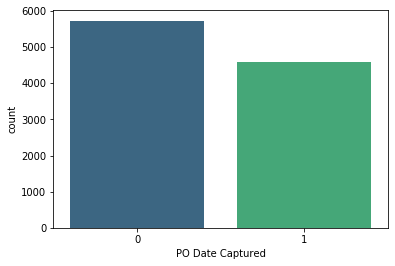

In [23]:
# PO Sent to Vendor Date

# As well as the Dates of PQ, # PO has the same problem
# since many item haven't undergone one or both steps

df["PO Date Captured"] = df["PO Sent to Vendor Date"].apply(lambda x: 0 if " " in x else 1)

sns.countplot(df["PO Date Captured"], palette = "viridis")

df.drop(["PQ First Sent to Client Date", "PO Sent to Vendor Date"], axis = 1, inplace = True)

In [24]:
# Product Group

# Contains the same information carried by "Sub Classification",
# but the latter is more clear, and it includes the
# distinction between adults and pediatric medicines

df.drop("Product Group", axis = 1, inplace = True)

In [25]:
# Sub Classification

df["Sub Classification"] = df["Sub Classification"].apply(lambda x: "HIV test" if x == "HIV test - Ancillary" else x)

df = pd.concat([df, pd.get_dummies(df["Sub Classification"], drop_first = True)], axis = 1)
df.drop("Sub Classification", axis = 1, inplace = True)

In [26]:
#Dosage Form


# The main effort was to reduce the dimensionality of the feature, in
# a way that was still relevant for the domain of medicines

def reduce_dos(df, c):
    nc = []
    for x in df[c]:
        if x == "Tablet - FDC": nc += [ x[:-6] ]
        elif x == "Chewable/dispersible tablet": nc += [ x[-6:].capitalize() ]
        elif x == "Chewable/dispersible tablet - FDC": nc += [ x[-12:-6].capitalize() ]   
        elif x == "Tablet - FDC + blister": nc += [ x[:6] ]
        elif x == "Tablet - blister": nc += [ x[:6] ]
        elif x == "Tablet - FDC + co-blister": nc += [ x[:6] ]
    
        elif x == "Delayed-release capsules": nc += [ x[-8:-1].capitalize() ]
        elif x == "Delayed-release capsules - blister": nc += [ x[16:-11].capitalize() ]
        
        elif x == "Test kit - Ancillary": nc += [ x[:8] ]
    
        elif x == "Oral solution": nc += [ x[:-5] + "/sus" ]
        elif x == "Oral suspension": nc += [ x[:4] + " sol/" + x[5:8] ]
        elif x == "Oral powder": nc += [ x.replace("powder", "sol/sus") ]
        elif x == "Powder for oral solution": nc += [ x[11:].replace("solution", "sol/sus").capitalize() ]
    
        else: nc += [ x ]
            
    return nc

df["Dosage Form"] = reduce_dos(df, "Dosage Form")
df = pd.concat([df, pd.get_dummies(df["Dosage Form"], drop_first = True)], axis = 1)
df.drop("Dosage Form", axis = 1, inplace = True)

In [27]:
# Line Item Insurance

# This will be the target feature so, in order
# not to disrupt or influence the prediction models,
# I am dropping all rows where the value is empty.

df.dropna(axis = 0, inplace = True)
df.drop(df[df["Line Item Insurance (USD)"] > 2500].index, inplace = True)
df.reset_index(drop = True, inplace = True)

In [28]:
# Fix "Coords" columns

# order: LAT, LON

df["Manufacturing Site LAT"] = [x[0] for x in df["Manufacturing Site Coords"]]
df["Manufacturing Site LONG"] = [x[1] for x in df["Manufacturing Site Coords"]]

df["Country LAT"] = [x[0] for x in df["Country Coords"]]
df["Country LONG"] = [x[1] for x in df["Country Coords"]]

## Prediction models

* Task of **binary classification** on ***DIRECT DROP***
    - Logistic Regression (+ Grid Search for tuning)
    - Decision Tree Classifier
    - k-Nearest Neighbors

In [29]:
X = df.drop(["Line Item Insurance (USD)", "Shipment Mode", "Direct_drop",
             "Manufacturing Site Coords", "Country Coords"], axis = 1).values
# The columns with "... Coords" are made of tuples
y = df["Direct_drop"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logi_param = {"penalty":["l2", "none", "l1", "elasticnet"],
              "solver":["newton-cg", "lbfgs", "sag", "saga"],
              "multi_class":["auto", "ovr", "multinomial", "liblinear"]}

# RMK: only "saga" solver allows the "elasticnet" penalty
# RMK: "sag", "newton-cg" and "lbfgs" solvers allow only "l2" or "none" penalty
# RMK: "liblinear" does not allow "none" as penalty

# But to test all these combinations, I needed
# to add to the dictionary all possible instances

logireg = LogisticRegression(random_state = 101, n_jobs = -1, max_iter = 3000, multi_class = "ovr") # ovr for binary
logi_grid = GridSearchCV(logireg, logi_param, cv = 3, verbose = 1, n_jobs = -1)
logi_grid.fit(X_train, y_train)

print(logi_grid.best_estimator_)
print(logi_grid.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  1.0min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3000,
                   multi_class='auto', n_jobs=-1, penalty='none',
                   random_state=101, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
{'multi_class': 'auto', 'penalty': 'none', 'solver': 'saga'}


In [31]:
from sklearn.metrics import classification_report,confusion_matrix

logreg = LogisticRegression(multi_class = "auto", penalty = "none", solver = "saga",
                            random_state = 101, n_jobs = -1, max_iter = 3000)

logreg.fit(X_train, y_train)
loreg_pred = logreg.predict(X_test)

print(confusion_matrix(y_test, loreg_pred))
print(classification_report(y_test, loreg_pred))

# The results of the logistic regression are quite impressive,
# only after a 3-fold cross validation. Scores are almost perfect,
# nevertheless the classes were fairly good balanced.

[[1567    3]
 [  18 1394]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1570
           1       1.00      0.99      0.99      1412

    accuracy                           0.99      2982
   macro avg       0.99      0.99      0.99      2982
weighted avg       0.99      0.99      0.99      2982



In [32]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state = 101)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)

print(confusion_matrix(y_test, tree_pred))
print(classification_report(y_test, tree_pred))

# The performance of this model are even more impressive. This is not
# a case, but it probably means that only some instances are more
# difficult to predict, while the majority is fairly easier
# (also considering the amount of total features and total instances).
# In general, this made me think that this classification task is too
# easy for this models OR that the amount of feature is far more than enough
# to explain and predict the variable "Direct_drop".

[[1570    0]
 [   3 1409]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1570
           1       1.00      1.00      1.00      1412

    accuracy                           1.00      2982
   macro avg       1.00      1.00      1.00      2982
weighted avg       1.00      1.00      1.00      2982



In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

print(confusion_matrix(y_test, knn_pred))
print(classification_report(y_test, knn_pred))

[[1554   16]
 [  19 1393]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1570
           1       0.99      0.99      0.99      1412

    accuracy                           0.99      2982
   macro avg       0.99      0.99      0.99      2982
weighted avg       0.99      0.99      0.99      2982



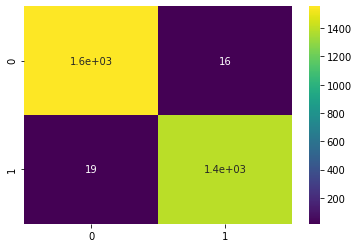

In [34]:
sns.heatmap(confusion_matrix(y_test, knn_pred), cmap = "viridis", annot = True)